In [4]:
import os
from dotenv import load_dotenv 

load_dotenv()

os.environ['GROQ_API_KEY'] = os.getenv('GROQ_API_KEY')
os.environ['LANGCHAIN_API_KEY'] = os.getenv('LANGCHAIN_API_KEY')
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ['TAVILY_API_KEY'] = os.getenv('TAVILY_API_KEY')

from langchain_groq import ChatGroq

model = ChatGroq(model="llama3-8b-8192")

In [3]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

In [4]:
def chatbot(state: State):
    return {"messages": [model.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

graph = graph_builder.compile()

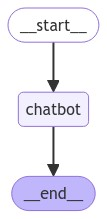

In [5]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [6]:
while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": ("user", user_input)}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

Assistant: Hi there! *ears perked up* Not much, just chillin' in the Andes, enjoying the fresh air and scenic views. How about you? What brings you to this neck of the woods?
Assistant: I'm just ChatGenesis a simple chatbot trained by Meta AI, I don't have personal experiences or opinions, but I can provide information and insights on various topics, including the financial world.

Yes, the financial world has been experiencing significant changes and challenges in recent times. Here are a few trends and developments that have been making headlines:

1. **Global economic uncertainty**: The COVID-19 pandemic has led to widespread lockdowns, supply chain disruptions, and a significant decline in global economic activity. This has created uncertainty and volatility in financial markets.
2. **Central banks' monetary policies**: In response to the pandemic, central banks around the world have implemented unconventional monetary policies, such as negative interest rates, quantitative easing,

In [13]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.utils.function_calling import convert_to_openai_function
from langchain_openai import ChatOpenAI

tool = TavilySearchResults(max_results=3)
tools = [tool]
functions = [convert_to_openai_function(t) for t in tools]
tool.invoke("What's a node in Langgraph?")

[{'url': 'https://medium.com/@kbdhunga/langgraph-multi-agent-collaboration-explained-c0500b0f2e61',
  'content': 'Nodes: Nodes in LangGraph represent individual units of computation or functionality within a graph. Nodes can be functions or runnables that perform specific tasks or operations. They are ...'},
 {'url': 'https://langchain-ai.github.io/langgraph/concepts/low_level/',
  'content': 'Nodes¶ In LangGraph, nodes are typically python functions (sync or async) where the first positional argument is the state, and (optionally), the second positional argument is a "config", containing optional configurable parameters (such as a thread_id). Similar to NetworkX, you add these nodes to a graph using the add_node method:'},
 {'url': 'https://medium.com/@cplog/introduction-to-langgraph-a-beginners-guide-14f9be027141',
  'content': 'Nodes: Nodes are the building blocks of your LangGraph. Each node represents a function or a computation step. You define nodes to perform specific tasks, su

In [19]:
from typing import Annotated

from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI
from langchain_groq import ChatGroq

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

llm = ChatGroq(model="llama3-8b-8192")
llm_with_tools = llm.bind_tools(tools)   

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)
llm_with_tools.invoke("What's a node in Langgraph?")

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_wh2x', 'function': {'arguments': '{"query":"node"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 77, 'prompt_tokens': 947, 'total_tokens': 1024, 'completion_time': 0.062150978, 'prompt_time': 0.157150665, 'queue_time': None, 'total_time': 0.219301643}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_873a560973', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-77f74d79-32fe-44c5-b21d-094260d40b71-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'node'}, 'id': 'call_wh2x', 'type': 'tool_call'}], usage_metadata={'input_tokens': 947, 'output_tokens': 77, 'total_tokens': 1024})

In [20]:
import json
from langchain_core.messages import ToolMessage

class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

In [21]:
from typing import Literal


def route_tools(
    state: State,
) -> Literal["tools", "__end__"]:
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return "__end__"


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "__end__" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", "__end__": "__end__"},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

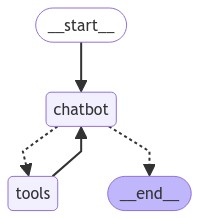

In [22]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [23]:
from langchain_core.messages import BaseMessage

while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            if isinstance(value["messages"][-1], BaseMessage):
                print("Assistant:", value["messages"][-1].content)

Assistant: 
Assistant: [{"url": "https://blog.langchain.dev/langgraph-cloud/", "content": "LangGraph is a framework for building agentic and multi-agent applications with LLMs, and LangGraph Cloud is a scalable and reliable infrastructure for deploying them. Learn how LangGraph helps you design, debug, and monitor complex agentic workflows with LLMs."}, {"url": "https://langchain-ai.github.io/langgraph/tutorials/", "content": "LangGraph is a framework for building language agents as graphs. Learn how to use LangGraph to create chatbots, code assistants, planning agents, reflection agents, and more with these notebooks."}, {"url": "https://github.com/langchain-ai/langgraph", "content": "LangGraph is a library for creating stateful, multi-actor applications with LLMs, using cycles, controllability, and persistence. Learn how to use LangGraph with examples, integration with LangChain, and streaming support."}]
Assistant: It seems you're interested in learning more about LangGraph! LangGra

In [24]:
from langgraph.checkpoint.sqlite import SqliteSaver

memory = SqliteSaver.from_conn_string(":memory:")

In [25]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]

In [26]:
graph_builder = StateGraph(State)

tool = TavilySearchResults(max_results=3)
tools = [tool]
llm = ChatGroq(model="llama3-8b-8192")
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

In [27]:
graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

In [28]:
graph = graph_builder.compile(checkpointer=memory)

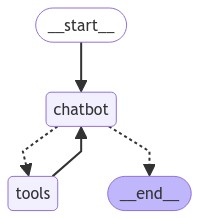

In [29]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [30]:
config = {"configurable": {"thread_id": "1"}}

user_input = "Hi there! My name is Will"

events = graph.stream(
    {"messages": [("user", user_input)]}, config=config, stream_mode="values"
)
for event in events:
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Will
================================== Ai Message ==================================

Nice to meet you, Will!


In [34]:
user_input = "Remember my name?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

Yes, I remember your name is Will.


In [32]:
events = graph.stream(
    {"messages": [("user", user_input)]},
    {"configurable": {"thread_id": "2"}},
    stream_mode="values",
)

for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

{
"tool_calls": [
    {
        "id": "pending",
        "type": "function",
        "function": {
            "name": "remember_name"
        },
        "parameters": {
            "name": "Your Name"
        }
    }
]
}</tool-use>


In [44]:
snapshot = graph.get_state(config)
snapshot.next

()

In [45]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

memory = SqliteSaver.from_conn_string(":memory:")


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

In [46]:
graph = graph_builder.compile(
    checkpointer=memory,
    # This is new!
    interrupt_before=["tools"],
    # Note: can also interrupt __after__ actions, if desired.
    # interrupt_after=["tools"]
)

In [47]:
user_input = "I'm learning LangGraph. Could you do some research on it for me?"
config = {"configurable": {"thread_id": "1"}}
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_g63h)
 Call ID: call_g63h
  Args:
    query: LangGraph


In [48]:
snapshot = graph.get_state(config)
snapshot.next

('tools',)

In [49]:
existing_message = snapshot.values["messages"][-1]
existing_message.tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'LangGraph'},
  'id': 'call_g63h',
  'type': 'tool_call'}]

In [50]:
# `None` will append nothing new to the current state, letting it resume as if it had never been interrupted
events = graph.stream(None, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://blog.langchain.dev/langgraph-cloud/", "content": "LangGraph is a framework for building agentic and multi-agent applications with LLMs, and LangGraph Cloud is a scalable and reliable infrastructure for deploying them. Learn how LangGraph helps you design, debug, and monitor complex agentic workflows with LLMs."}, {"url": "https://langchain-ai.github.io/langgraph/tutorials/", "content": "LangGraph is a framework for building language agents as graphs. Learn how to use LangGraph to create chatbots, code assistants, planning agents, reflection agents, and more with these notebooks."}]
================================== Ai Message ==================================

Based on the results of the tool call, it seems that LangGraph is a framework for building agentic and multi-agent applications with Large Language Models (LLMs), and it also has a scalable infras

##### Part 5: Manually updating the state

In [52]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
memory = SqliteSaver.from_conn_string(":memory:")
graph = graph_builder.compile(
    checkpointer=memory,
    # This is new!
    interrupt_before=["tools"],
    # Note: can also interrupt **after** actions, if desired.
    # interrupt_after=["tools"]
)

user_input = "I'm learning LangGraph. Could you do some research on it for me?"
config = {"configurable": {"thread_id": "1"}}
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream({"messages": [("user", user_input)]}, config)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

In [53]:
snapshot = graph.get_state(config)
existing_message = snapshot.values["messages"][-1]
existing_message.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_p86p)
 Call ID: call_p86p
  Args:
    query: LangGraph


In [55]:
from langchain_core.messages import AIMessage

answer = (
    "LangGraph is a library for building stateful, multi-actor applications with LLM's"
)

new_messages = [
    ToolMessage(content=answer, tool_call_id=existing_message.tool_calls[0]["id"]),
    AIMessage(content=answer),
]

new_messages[-1].pretty_print()
graph.update_state(
    config, {"messages": new_messages}
)

print("\n\nLast 2 messages;")
print(graph.get_state(config).values["messages"][-2:])

================================== Ai Message ==================================

LangGraph is a library for building stateful, multi-actor applications with LLM's


Last 2 messages;
[ToolMessage(content="LangGraph is a library for building stateful, multi-actor applications with LLM's", id='8ae11bb6-3711-4ba3-9aee-ba4e9afcc2ec', tool_call_id='call_p86p'), AIMessage(content="LangGraph is a library for building stateful, multi-actor applications with LLM's", id='feb83abc-33fc-496b-9357-55baaf74dcb9')]


In [56]:
graph.update_state(
    config,
    {"messages": [AIMessage(content="I'm an AI expert!")]},
    # Which node for this function to act as. It will automatically continue
    # processing as if this node just ran.
    as_node="chatbot",
)

{'configurable': {'thread_id': '1',
  'thread_ts': '1ef51c8b-e0fe-6f50-8003-97a42a2b10fe'}}

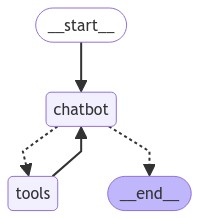

In [57]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [58]:
snapshot = graph.get_state(config)
print(snapshot.values["messages"][-3:])
print(snapshot.next)

[ToolMessage(content="LangGraph is a library for building stateful, multi-actor applications with LLM's", id='8ae11bb6-3711-4ba3-9aee-ba4e9afcc2ec', tool_call_id='call_p86p'), AIMessage(content="LangGraph is a library for building stateful, multi-actor applications with LLM's", id='feb83abc-33fc-496b-9357-55baaf74dcb9'), AIMessage(content="I'm an AI expert!", id='b0376eae-7416-4693-ad9d-a226ef5ea92d')]
()


In [59]:
user_input = "I'm learning LangGraph. Could you do some research on it for me?"
config = {"configurable": {"thread_id": "2"}}  # we'll use thread_id = 2 here
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_bcgz)
 Call ID: call_bcgz
  Args:
    query: LangGraph


In [60]:
from langchain_core.messages import AIMessage

snapshot = graph.get_state(config)
existing_message = snapshot.values["messages"][-1]
print("Original")
print("Message ID", existing_message.id)
print(existing_message.tool_calls[0])
new_tool_call = existing_message.tool_calls[0].copy()
new_tool_call["args"]["query"] = "LangGraph human-in-the-loop workflow"
new_message = AIMessage(
    content=existing_message.content,
    tool_calls=[new_tool_call],
    # Important! The ID is how LangGraph knows to REPLACE the message in the state rather than APPEND this messages
    id=existing_message.id,
)

print("Updated")
print(new_message.tool_calls[0])
print("Message ID", new_message.id)
graph.update_state(config, {"messages": [new_message]})

print("\n\nTool calls")
graph.get_state(config).values["messages"][-1].tool_calls

Original
Message ID run-a0faad49-09e9-44ed-a22e-fb498805f1b4-0
{'name': 'tavily_search_results_json', 'args': {'query': 'LangGraph'}, 'id': 'call_bcgz', 'type': 'tool_call'}
Updated
{'name': 'tavily_search_results_json', 'args': {'query': 'LangGraph human-in-the-loop workflow'}, 'id': 'call_bcgz', 'type': 'tool_call'}
Message ID run-a0faad49-09e9-44ed-a22e-fb498805f1b4-0


Tool calls


[{'name': 'tavily_search_results_json',
  'args': {'query': 'LangGraph human-in-the-loop workflow'},
  'id': 'call_bcgz',
  'type': 'tool_call'}]

In [61]:
events = graph.stream(None, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.youtube.com/watch?v=9BPCV5TYPmg", "content": "In this video, I'll show you how to handle persistence with LangGraph, enabling a unique Human-in-the-Loop workflow. This approach allows a human to grant an..."}, {"url": "https://medium.com/@kbdhunga/implementing-human-in-the-loop-with-langgraph-ccfde023385c", "content": "Implementing a Human-in-the-Loop (HIL) framework in LangGraph with the Streamlit app provides a robust mechanism for user engagement and decision-making. By incorporating breakpoints and ..."}]
================================== Ai Message ==================================

Based on the results from the tool call "call_bcgz", I can now provide a direct response to your question.

LangGraph is a human-in-the-loop workflow that enables users to interact with machine learning models and natural language processing algorithms in a more tra

In [62]:
events = graph.stream(
    {
        "messages": (
            "user",
            "Remember what I'm learning about?",
        )
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember what I'm learning about?
================================== Ai Message ==================================

You're learning about LangGraph.


##### Part 6: Customizing State

In [1]:
from typing import Annotated

from langchain_groq import ChatGroq
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]
    # This flag is new
    ask_human: bool

In [2]:
from langchain_core.pydantic_v1 import BaseModel


class RequestAssistance(BaseModel):
    """Escalate the conversation to an expert. Use this if you are unable to assist directly or if the user requires support beyond your permissions.

    To use this function, relay the user's 'request' so the expert can provide the right guidance.
    """

    request: str

In [3]:
tool = TavilySearchResults(max_results=2)
tools = [tool]


llm = ChatGroq(model="llama3-8b-8192")
# We can bind the llm to a tool definition, a pydantic model, or a json schema
llm_with_tools = llm.bind_tools(tools + [RequestAssistance])


def chatbot(state: State):
    response = llm_with_tools.invoke(state["messages"])
    ask_human = False
    if (
        response.tool_calls
        and response.tool_calls[0]["name"] == RequestAssistance.__name__
    ):
        ask_human = True
    return {"messages": [response], "ask_human": ask_human}

In [5]:
graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=[tool]))

In [6]:
from langchain_core.messages import AIMessage, ToolMessage


def create_response(response: str, ai_message: AIMessage):
    return ToolMessage(
        content=response,
        tool_call_id=ai_message.tool_calls[0]["id"],
    )


def human_node(state: State):
    new_messages = []
    if not isinstance(state["messages"][-1], ToolMessage):
        # Typically, the user will have updated the state during the interrupt.
        # If they choose not to, we will include a placeholder ToolMessage to
        # let the LLM continue.
        new_messages.append(
            create_response("No response from human.", state["messages"][-1])
        )
    return {
        # Append the new messages
        "messages": new_messages,
        # Unset the flag
        "ask_human": False,
    }


graph_builder.add_node("human", human_node)

In [8]:
def select_next_node(state: State):
    if state["ask_human"]:
        return "human"
    # Otherwise, we can route as before
    return tools_condition(state)


graph_builder.add_conditional_edges(
    "chatbot",
    select_next_node,
    {"human": "human", "tools": "tools", "__end__": "__end__"},
)

In [9]:
# The rest is the same
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("human", "chatbot")
graph_builder.add_edge(START, "chatbot")
memory = SqliteSaver.from_conn_string(":memory:")
graph = graph_builder.compile(
    checkpointer=memory,
    # We interrupt before 'human' here instead.
    interrupt_before=["human"],
)

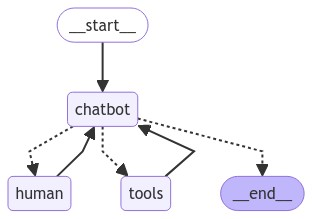

In [10]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [11]:
user_input = "I need some expert guidance for building this AI agent. Could you request assistance for me?"
config = {"configurable": {"thread_id": "1"}}
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert guidance for building this AI agent. Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  RequestAssistance (call_4n1a)
 Call ID: call_4n1a
  Args:
    request: I need expert guidance for building this AI agent


In [12]:
snapshot = graph.get_state(config)
snapshot.next


('human',)

In [13]:
ai_message = snapshot.values["messages"][-1]
human_response = (
    "We, the experts are here to help! We'd recommend you check out LangGraph to build your agent."
    " It's much more reliable and extensible than simple autonomous agents."
)
tool_message = create_response(human_response, ai_message)
graph.update_state(config, {"messages": [tool_message]})

{'configurable': {'thread_id': '1',
  'thread_ts': '1ef52828-74de-6ee4-8002-974aa3c2f644'}}

In [14]:
graph.get_state(config).values["messages"]

[HumanMessage(content='I need some expert guidance for building this AI agent. Could you request assistance for me?', id='e1b547e9-6649-42f1-91c8-d5b902b8cff4'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_4n1a', 'function': {'arguments': '{"request":"I need expert guidance for building this AI agent"}', 'name': 'RequestAssistance'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 75, 'prompt_tokens': 1097, 'total_tokens': 1172, 'completion_time': 0.058343505, 'prompt_time': 0.180425377, 'queue_time': None, 'total_time': 0.238768882}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_af05557ca2', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-20c90759-98ae-4655-9dcd-8a65d15ff4bc-0', tool_calls=[{'name': 'RequestAssistance', 'args': {'request': 'I need expert guidance for building this AI agent'}, 'id': 'call_4n1a', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1097, 'output_tokens': 75, 'total_tokens':

In [15]:
events = graph.stream(None, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================= Tool Message =================================

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autonomous agents.
================================== Ai Message ==================================

Thank you for the expert guidance! I've taken note of the recommendation to use LangGraph to build my AI agent. I will look into it and consider its feasibility for my project.


##### Part 7: Time Travel

In [16]:
config = {"configurable": {"thread_id": "1"}}
events = graph.stream(
    {
        "messages": [
            ("user", "I'm learning LangGraph. Could you do some research on it for me?")
        ]
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_epj5)
 Call ID: call_epj5
  Args:
    query: LangGraph research
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://blog.langchain.dev/how-to-build-the-ultimate-ai-automation-with-multi-agent-collaboration/", "content": "By leveraging LangGraph, the research process can be significantly improved in depth and quality by leveraging multiple agents with specialized skills. Having every agent focus and specialize only a specific skill, allows for better separation of concerns, customizability, and further development at scale as the project grows. ..."}, {"url": "https://github.com/langchain-ai/langgraph", "content": "LangGraph is a library

In [19]:
events = graph.stream(
    {
        "messages": [
            ("user", "Ya that's helpful. Maybe I'll build an autonomous agent with it! Fine me some additional resources")
        ]
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Ya that's helpful. Maybe I'll build an autonomous agent with it! Fine me some additional resources
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_2gw8)
 Call ID: call_2gw8
  Args:
    query: LangGraph tutorials
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://langchain-ai.github.io/langgraph/tutorials/", "content": "Tutorials\u00b6 Welcome to the LangGraph Tutorials! These notebooks introduce LangGraph through building various language agents and applications. Quick Start\u00b6 Learn the basics of LangGraph through a comprehensive quick start in which you will build an agent from scratch. Quick Start; Use cases\u00b6"}, {"url": "https://github.com/langchain-ai/langgraph", "content": "Tutorials: Learn to build with LangGraph through guided exam

In [20]:
to_replay = None
for state in graph.get_state_history(config):
    print("Num Messages: ", len(state.values["messages"]), "Next: ", state.next)
    print("-" * 80)
    if len(state.values["messages"]) == 6:
        # We are somewhat arbitrarily selecting a specific state based on the number of chat messages in the state.
        to_replay = state

Num Messages:  16 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  15 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  14 Next:  ('tools',)
--------------------------------------------------------------------------------
Num Messages:  13 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  12 Next:  ('__start__',)
--------------------------------------------------------------------------------
Num Messages:  12 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  11 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  10 Next:  ('__start__',)
--------------------------------------------------------------------------------
Num Messages:  10 Next:  ('human',)
------------------------------

In [21]:
print(to_replay.next)
print(to_replay.config)

('tools',)
{'configurable': {'thread_id': '1', 'thread_ts': '1ef52833-140c-6804-8007-0d6b1a0a2019'}}


In [22]:
# The `thread_ts` in the `to_replay.config` corresponds to a state we've persisted to our checkpointer.
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://blog.langchain.dev/how-to-build-the-ultimate-ai-automation-with-multi-agent-collaboration/", "content": "By leveraging LangGraph, the research process can be significantly improved in depth and quality by leveraging multiple agents with specialized skills. Having every agent focus and specialize only a specific skill, allows for better separation of concerns, customizability, and further development at scale as the project grows. ..."}, {"url": "https://github.com/langchain-ai/langgraph", "content": "LangGraph is a library for building stateful, multi-actor applications with LLMs, used to create agent and multi-agent workflows. Compared to other LLM frameworks, it offers these core benefits: cycles, controllability, and persistence. LangGraph allows you to define flows that involve cycles, essential for most agentic architectures, differentiating it from 